<a href="https://colab.research.google.com/github/Mohammed-khair/ResNet/blob/main/ResNets.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!git clone https://github.com/Mohammed-khair/ResNet.git

Cloning into 'ResNet'...
remote: Enumerating objects: 17, done.
remote: Counting objects: 100% (17/17), done.
remote: Compressing objects: 100% (14/14), done.
remote: Total 17 (delta 1), reused 0 (delta 0), pack-reused 0
Receiving objects: 100% (17/17), 4.54 KiB | 4.54 MiB/s, done.
Resolving deltas: 100% (1/1), done.


# Residual Networks



This project was done as an excercise in the following course [Coursera: Convolutional neural network](https://www.coursera.org/learn/convolutional-neural-networks)

In this notebook, we will be building ResNets as introduced by [He et al.](https://arxiv.org/pdf/1512.03385.pdf). ResNets are very deep convolutional nueral networks that can learn very complex functions. However, they are very hard to train and will require a GPU to run.
* On google colab, you can enable GPU from `runtime -> change runtime resources -> Hardware Accelerator: GPU `

In particular, we will do the following:
- Implement the basic building blocks of ResNets in a deep neural network using Keras
- Put together these building blocks to implement and train a state-of-the-art neural network for image classification
- Implement a skip connection in your network

### Problems with very deep neural networks
* **Vanishing Gradient Problem:** In very deep neural networks, during backpropagation, gradients can become extremely small as they propagate backward through many layers. This makes it challenging for the lower layers to update their weights effectively, leading to slow or stalled learning.
* **Exploding Gradient Problem:** Conversely, gradients can also become very large, causing weight updates to be too drastic. This may lead to unstable training and cause the model to diverge.
* **Overfitting:** Deeper networks tend to have a higher capacity to memorize the training data, making them more prone to overfitting, especially when training data is limited

Residual Blocks help solve these problems

Let us start with the imports

In [1]:
import tensorflow as tf
import numpy as np
import scipy.misc
from tensorflow.keras.applications.resnet_v2 import ResNet50V2
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet_v2 import preprocess_input, decode_predictions
from tensorflow.keras import layers
from tensorflow.keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.initializers import random_uniform, glorot_uniform, constant, identity
from tensorflow.python.framework.ops import EagerTensor
from matplotlib.pyplot import imshow
from tensorflow.keras.layers import Input
import h5py
import matplotlib.pyplot as plt



### Residual Blocks
Residual blocks or "skip connection" allows the model to skip layers. This shortcut makes it very easy for one of the blocks to learn an identity function. Thus, stacking up many blocks will do little to hurt the performance of the network.
There are two types of blocks: **identity block** and the **convolutional block**.

### **Identity Block**
In the identity block, input activation has the same dimension as the output activation. Here is the architecture of the identity block.

*input* &rarr; Conv2D &rarr; Batch Norm &rarr; ReLU &rarr;&rarr; Conv2D &rarr; Batch Norm &rarr; ReLU &rarr;&rarr; Conv2D &rarr; Batch Norm &rarr;&rarr; ReLU(add output to *input*)



In [2]:
def identity_block(X, f, filters, training=True, initializer=random_uniform):
    """
    Implementation of the identity block as defined in Figure 4

    Arguments:
    X -- input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)
    f -- integer, specifying the shape of the middle CONV's window for the main path
    filters -- python list of integers, defining the number of filters in the CONV layers of the main path
    training -- True: Behave in training mode
                False: Behave in inference mode
    initializer -- to set up the initial weights of a layer. Equals to random uniform initializer

    Returns:
    X -- output of the identity block, tensor of shape (m, n_H, n_W, n_C)
    """

    # Retrieve Filters
    F1, F2, F3 = filters

    # Save the input value. You'll need this later to add back to the main path.
    X_shortcut = X

    # First component of main path
    X = Conv2D(filters = F1, kernel_size = 1, strides = (1,1), padding = 'valid', kernel_initializer = initializer(seed=0))(X)
    X = BatchNormalization(axis = 3)(X, training = training)
    X = Activation('relu')(X)

    ## Second component of main path
    X = Conv2D(filters = F2, kernel_size = (f, f), strides = (1, 1), padding = 'same', kernel_initializer = initializer(seed=0))(X)
    X = BatchNormalization(axis = 3)(X, training = training)
    X = Activation('relu')(X)

    ## Third component of main path
    X = Conv2D(filters = F3, kernel_size = 1, strides = (1,1), padding = 'valid', kernel_initializer = initializer(seed=0))(X)
    X = BatchNormalization(axis = 3)(X, training = training)

    ## Final step: Add shortcut value to main path, and pass it through a RELU activation
    X = tf.add(X, X_shortcut)
    X = Activation('relu')(X)

    return X

### The Convolutional Block
The convolutional block is used when the input and output dimensions don't match up. Unlike the identity block, the convolutional block has a CONV2D layer in the shortcut path.

main path:
*input* &rarr; Conv2D &rarr; Batch Norm &rarr; ReLU &rarr;&rarr; Conv2D &rarr; Batch Norm &rarr; ReLU &rarr;&rarr; Conv2D &rarr; Batch Norm &rarr;&rarr; First output

Shortcut path:
*input* &rarr; Conv2D &rarr; Batch Norm &rarr; second output

The final output is the addition of the first and second output




In [3]:
def convolutional_block(X, f, filters, s = 2, training=True, initializer=glorot_uniform):
    """
    Implementation of the convolutional block as defined in Figure 4

    Arguments:
    X -- input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)
    f -- integer, specifying the shape of the middle CONV's window for the main path
    filters -- python list of integers, defining the number of filters in the CONV layers of the main path
    s -- Integer, specifying the stride to be used
    training -- True: Behave in training mode
                False: Behave in inference mode
    initializer -- to set up the initial weights of a layer. Equals to Glorot uniform initializer,
                   also called Xavier uniform initializer.

    Returns:
    X -- output of the convolutional block, tensor of shape (m, n_H, n_W, n_C)
    """

    # Retrieve Filters
    F1, F2, F3 = filters

    # Save the input value
    X_shortcut = X

    # First component of main path glorot_uniform
    X = Conv2D(filters = F1, kernel_size = 1, strides = (s, s), padding='valid', kernel_initializer = initializer(seed=0))(X)
    X = BatchNormalization(axis = 3)(X, training=training)
    X = Activation('relu')(X)

    ## Second component of main path
    X = Conv2D(filters = F2, kernel_size = (f, f), strides = (1, 1), padding = 'same', kernel_initializer = initializer(seed=0))(X)
    X = BatchNormalization(axis = 3)(X, training = training)
    X = Activation('relu')(X)

    ## Third component of main path
    X = Conv2D(filters = F3, kernel_size = 1, strides = (1,1), padding = 'valid', kernel_initializer = initializer(seed=0))(X)
    X = BatchNormalization(axis = 3)(X, training = training)

    # Shortcut path
    X_shortcut = Conv2D(filters = F3, kernel_size = 1, strides = (s,s), padding = 'valid', kernel_initializer = initializer(seed=0))(X_shortcut)
    X_shortcut = BatchNormalization(axis = 3)(X_shortcut, training=training)

    # Final step: Add shortcut value to main path, and pass it through a RELU activation
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)

    return X

## Build the ResNet Model
The details of this ResNet-50 model are:
- Zero-padding pads the input with a pad of (3,3)
- Stage 1:
    - The 2D Convolution has 64 filters of shape (7,7) and uses a stride of (2,2).
    - BatchNorm is applied to the 'channels' axis of the input.
    - MaxPooling uses a (3,3) window and a (2,2) stride.
- Stage 2:
    - The convolutional block uses three sets of filters of size [64,64,256], "f" is 3, and "s" is 1.
    - The 2 identity blocks use three sets of filters of size [64,64,256], and "f" is 3.
- Stage 3:
    - The convolutional block uses three sets of filters of size [128,128,512], "f" is 3 and "s" is 2.
    - The 3 identity blocks use three sets of filters of size [128,128,512] and "f" is 3.
- Stage 4:
    - The convolutional block uses three sets of filters of size [256, 256, 1024], "f" is 3 and "s" is 2.
    - The 5 identity blocks use three sets of filters of size [256, 256, 1024] and "f" is 3.
- Stage 5:
    - The convolutional block uses three sets of filters of size [512, 512, 2048], "f" is 3 and "s" is 2.
    - The 2 identity blocks use three sets of filters of size [512, 512, 2048] and "f" is 3.
- The 2D Average Pooling uses a window of shape (2,2).
- The 'flatten' layer doesn't have any hyperparameters.
- The Fully Connected (Dense) layer reduces its input to the number of classes using a softmax activation.


In [4]:
def ResNet50(input_shape = (64, 64, 3), classes = 6):
    """
    Stage-wise implementation of the architecture of the popular ResNet50:
    CONV2D -> BATCHNORM -> RELU -> MAXPOOL -> CONVBLOCK -> IDBLOCK*2 -> CONVBLOCK -> IDBLOCK*3
    -> CONVBLOCK -> IDBLOCK*5 -> CONVBLOCK -> IDBLOCK*2 -> AVGPOOL -> FLATTEN -> DENSE

    Arguments:
    input_shape -- shape of the images of the dataset
    classes -- integer, number of classes

    Returns:
    model -- a Model() instance in Keras
    """

    # Define the input as a tensor with shape input_shape
    X_input = Input(input_shape)


    # Zero-Padding
    X = ZeroPadding2D((3, 3))(X_input)

    # Stage 1
    X = Conv2D(64, (7, 7), strides = (2, 2), kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3)(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((3, 3), strides=(2, 2))(X)

    # Stage 2
    X = convolutional_block(X, f = 3, filters = [64, 64, 256], s = 1)
    X = identity_block(X, 3, [64, 64, 256])
    X = identity_block(X, 3, [64, 64, 256])

    ## Stage 3
    # `convolutional_block`
    X = convolutional_block(X, f = 3, filters = [128,128,512], s = 2)

    # the 3 `identity_block`
    X = identity_block(X, 3, [128,128,512])
    X = identity_block(X, 3, [128,128,512])
    X = identity_block(X, 3, [128,128,512])

    # Stage 4
    # add `convolutional_block`
    X = convolutional_block(X, f = 3, filters = [256,256,1024], s = 2)

    # the 5 `identity_block`
    X = identity_block(X, 3, [256,256,1024])
    X = identity_block(X, 3, [256,256,1024])
    X = identity_block(X, 3, [256,256,1024])
    X = identity_block(X, 3, [256,256,1024])
    X = identity_block(X, 3, [256,256,1024])

    # Stage 5
    # add `convolutional_block`
    X = convolutional_block(X, f = 3, filters = [512, 512, 2048], s = 2)

    # the 2 `identity_block`
    X = identity_block(X, 3, [512, 512, 2048])
    X = identity_block(X, 3, [512, 512, 2048])

    # AVGPOOL
    X = AveragePooling2D(pool_size=(2, 2))(X)

    # output layer
    X = Flatten()(X)
    X = Dense(classes, activation='softmax', kernel_initializer = glorot_uniform(seed=0))(X)

    # Create model
    model = Model(inputs = X_input, outputs = X)

    return model

Compile the model


In [5]:
model = ResNet50(input_shape = (64, 64, 3), classes = 6)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

### Load the Data and Split the Data into Train/Test Sets

In [8]:
#Load the training set
train_dataset = h5py.File('/content/train_signs.h5', "r")
X_train_orig = np.array(train_dataset["train_set_x"][:]) # your train set features
Y_train_orig = np.array(train_dataset["train_set_y"][:]) # your train set labels

#Load the testing set
test_dataset = h5py.File('/content/test_signs.h5', "r")
X_test_orig = np.array(test_dataset["test_set_x"][:]) # your test set features
Y_test_orig = np.array(test_dataset["test_set_y"][:]) # your test set labels

#Load the list of classes
classes = np.array(test_dataset["list_classes"][:]) # the list of classes

View 6 examples of the data

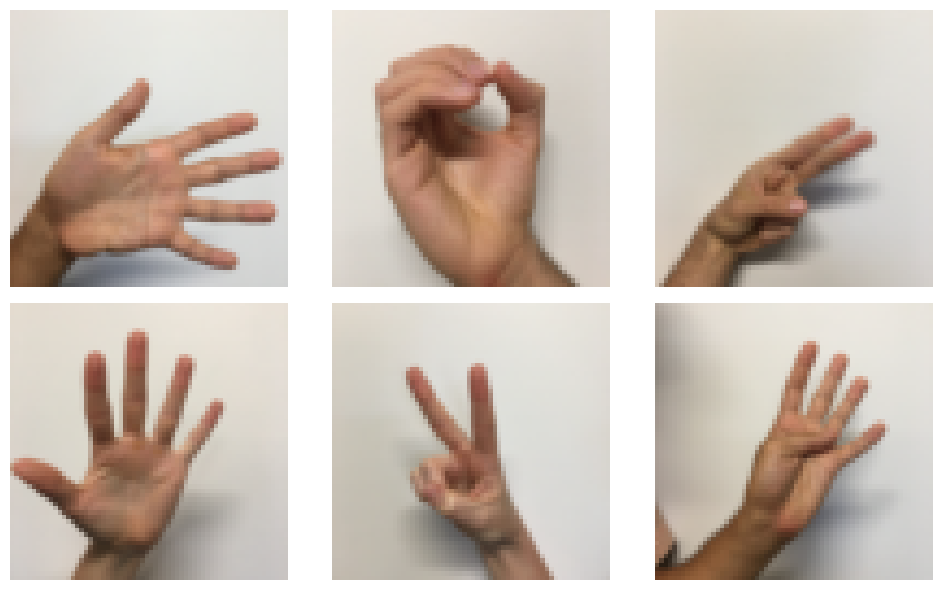

In [9]:
# Number of images you want to display
num_images_to_display = 6

# Randomly select six images from the list
images_list = X_train_orig[:num_images_to_display]

# Create a subplot grid to display multiple images
rows = 2  # Number of rows in the grid
cols = 3  # Number of columns in the grid

# Create a figure and axes using matplotlib
fig, axes = plt.subplots(rows, cols, figsize=(10, 6))

# Flatten the axes array to iterate through the subplots easily
axes = axes.flatten()

# Loop through the images and display them on the subplots
for i, image_array in enumerate(images_list):
    axes[i].imshow(image_array)
    axes[i].axis('off')  # Turn off axis ticks and labels for cleaner display

# Adjust the layout to avoid overlapping and improve visualization
plt.tight_layout()

# Show the plot with all the images
plt.show()

Normalize the input image vectors and reshape the output vectors

In [10]:
# Normalize image vectors
X_train = X_train_orig/255.
X_test = X_test_orig/255.

# Determine the number of classes
num_classes = np.max(Y_train_orig) + 1

# One-hot encode the y dataset
Y_train = np.eye(num_classes)[Y_train_orig]
Y_test = np.eye(num_classes)[Y_test_orig]

Print the shape of the training sets

In [11]:
print ("number of training examples = " + str(X_train.shape[0]))
print ("number of test examples = " + str(X_test.shape[0]))
print ("X_train shape: " + str(X_train.shape))
print ("Y_train shape: " + str(Y_train.shape))
print ("X_test shape: " + str(X_test.shape))
print ("Y_test shape: " + str(Y_test.shape))

number of training examples = 1080
number of test examples = 120
X_train shape: (1080, 64, 64, 3)
Y_train shape: (1080, 6)
X_test shape: (120, 64, 64, 3)
Y_test shape: (120, 6)


## Fit the Model

In [12]:
model.fit(X_train, Y_train, epochs = 10, batch_size = 32)

Epoch 1/10
34/34 [==============================] - 197s 5s/step - loss: 2.1076 - accuracy: 0.4389
Epoch 2/10
34/34 [==============================] - 177s 5s/step - loss: 1.0041 - accuracy: 0.6750
Epoch 3/10
34/34 [==============================] - 181s 5s/step - loss: 0.7115 - accuracy: 0.7620
Epoch 4/10
34/34 [==============================] - 189s 6s/step - loss: 0.3941 - accuracy: 0.8602
Epoch 5/10
34/34 [==============================] - 180s 5s/step - loss: 0.2364 - accuracy: 0.9148
Epoch 6/10
34/34 [==============================] - 180s 5s/step - loss: 0.1285 - accuracy: 0.9620
Epoch 7/10
34/34 [==============================] - 182s 5s/step - loss: 0.1030 - accuracy: 0.9741
Epoch 8/10
34/34 [==============================] - 185s 5s/step - loss: 0.1343 - accuracy: 0.9574
Epoch 9/10
34/34 [==============================] - 189s 6s/step - loss: 0.0791 - accuracy: 0.9676
Epoch 10/10
34/34 [==============================] - 183s 5s/step - loss: 0.1051 - accuracy: 0.9657


lets print the accuracy of the model

In [13]:
preds = model.evaluate(X_test, Y_test)
print ("Loss = " + str(preds[0]))
print ("Test Accuracy = " + str(preds[1]))

4/4 [==============================] - 5s 559ms/step - loss: 0.2977 - accuracy: 0.9083
Loss = 0.29766902327537537
Test Accuracy = 0.9083333611488342


### 90.8% Accuracy on the testing set